

Goals:

* Understand the convolutional arithmetic: convolutional operator in 1D and 2D domains, transposed convolution, pooling operators.
* Understand how deep neural networks could see the "invisible" signal, and learning the temporal association between the past and the future.
* Understand the deconvolution (a.k.a transposed convolution) operator and its role in the rise and fall of Generative Adversarial Network (GAN).


In [3]:
%tensorflow_version 2.x
%matplotlib inline
import os
import time
from collections import defaultdict

import numpy as np
import seaborn as sns
import tensorflow as tf
from matplotlib import pyplot as plt
from tensorflow import keras
import tensorflow_datasets as tfds
from IPython import display

sns.set()
mnist = tfds.load('mnist')
fmnist = tfds.load('fashion_mnist')

TensorFlow 2.x selected.


local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead set
data_dir=gs://tfds-data/datasets.





Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/1.0.0. Subsequent calls will reuse this data.


Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


Dataset fashion_mnist downloaded and prepared to /root/tensorflow_datasets/fashion_mnist/1.0.0. Subsequent calls will reuse this data.


# Question 1: Learning the Association via Local Receptive Field

To understand the convolution operator, visit `[1]`. A fast visualization is provided here:

* The blue boxes are input
* The cyan boxes are output
* The grey moving boxes are kernel, weight or filter

![alt text](https://drive.google.com/uc?export=view&id=14H-kAU0jQnnqekZaJ8NS1YL4OEDFPfKt)

_If you are still confusing about the convolutional operators, scroll to the end of this homework_


## **a)** Read and run the following code block, explain how the input images for convolutional neural network are prepared? And why they are processed in given way?


In [8]:
def process_image(data):
  r""" [0,255] -> [-1, 1]"""
  img = data['image']
  lab = data['label']
  img = (tf.cast(img, tf.float32) / 255.0 - 0.5) * 2.0
  return img, lab

def create_image_dataset(ds, batch_size=256, training=None):
  if training:
    ds = ds.shuffle(int(1e3))
  ds = ds.batch(batch_size).map(process_image).prefetch(
      tf.data.experimental.AUTOTUNE)
  return ds

train = create_image_dataset(mnist['train'], batch_size=256, training=True)
test = create_image_dataset(mnist['test'], batch_size=256, training=False)

image_shape = tf.data.experimental.get_structure(train)[0].shape[1:]
print("Image shape:", image_shape)

Image shape: (28, 28, 1)


<b> ANSWERS </b>

Building an effective neural network model requires careful consideration of the network architecture as well as the input data format.So, we need to pre-process our image data.In the process method, we commonly have the following parameters;<br>
->number of images<br>
->image height<br>
->image width<br>
->number of channels<br>
->number of levels per pixel<br>
Typically we have 3 channels of data corresponding to the colors Red, Green, Blue (RGB) pixel levels are usually [0,255].So, in the first process_image(data) function we are converting images into float numbers, or we can say we are casting, and then we are normalizing by dividing 255 because of the interval [0,255].

And then create_image_dataset(ds, batch_size=256, training=None) divides dataset into 256 by 256 batches.And Finally, testing the shape of the image dataset.So here we have, (28,28,1) means that we have images 28 x 28 and the 1 means that it is a gray scale image.

## **b)** Create a convolutional neural network and achieve > 98% accuracy on MNIST test set.

In [9]:
from keras.datasets import mnist
#download mnist data and split into train and test sets
(X_train, y_train), (X_test, y_test) = mnist.load_data()


import matplotlib.pyplot as plt


#check image shape
X_train[0].shape

#reshape data to fit model
X_train = X_train.reshape(60000,28,28,1)
X_test = X_test.reshape(10000,28,28,1)

from keras.utils import to_categorical
#one-hot encode target column
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_train[0]

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten
#create model
model = Sequential()
#add model layers
model.add(Conv2D(64, kernel_size=3, activation='relu', input_shape=(28,28,1)))
model.add(Conv2D(32, kernel_size=3, activation='relu'))
model.add(Flatten())
model.add(Dense(10, activation='softmax'))

#compile model using accuracy to measure model performance
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

#train the model
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=30, verbose=2)



Using TensorFlow backend.


11493376/11490434 [==============================] - 1s 0us/step
Train on 60000 samples, validate on 10000 samples
Epoch 1/30
60000/60000 - 13s - loss: 0.2419 - accuracy: 0.9514 - val_loss: 0.0947 - val_accuracy: 0.9734
Epoch 2/30
60000/60000 - 6s - loss: 0.0707 - accuracy: 0.9785 - val_loss: 0.0942 - val_accuracy: 0.9736
Epoch 3/30
60000/60000 - 6s - loss: 0.0488 - accuracy: 0.9848 - val_loss: 0.0925 - val_accuracy: 0.9736
Epoch 4/30
60000/60000 - 6s - loss: 0.0367 - accuracy: 0.9885 - val_loss: 0.0985 - val_accuracy: 0.9754
Epoch 5/30
60000/60000 - 6s - loss: 0.0275 - accuracy: 0.9914 - val_loss: 0.1077 - val_accuracy: 0.9758
Epoch 6/30
60000/60000 - 6s - loss: 0.0264 - accuracy: 0.9919 - val_loss: 0.1054 - val_accuracy: 0.9768
Epoch 7/30
60000/60000 - 6s - loss: 0.0188 - accuracy: 0.9943 - val_loss: 0.1353 - val_accuracy: 0.9738
Epoch 8/30
60000/60000 - 6s - loss: 0.0193 - accuracy: 0.9943 - val_loss: 0.1164 - val_accuracy: 0.9770
Epoch 9/30
60000/60000 - 6s - loss: 0.0168 - accurac

## **c)** Create a deep convolutional neural network satisfying the following description.


```
Input_shape: (None, 28, 28, 1)
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
conv2d_3 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 6, 6, 64)          18496     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 2, 2, 128)         204928    
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 1, 1, 128)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1290      
=================================================================
Total params: 225,034
Trainable params: 225,034
Non-trainable params: 0
```



In [13]:
print("Input_shape:", (None,) + image_shape)
from tensorflow.keras.layers import MaxPool2D

#create model
model = Sequential()
#add model layers
model.add(Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=(28,28,1)))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Conv2D(64,  kernel_size=(8,8), activation='relu'))
model.add(Conv2D(128,  kernel_size=(5,5), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(10, activation='softmax'))


print(model.summary())

Input_shape: (None, 28, 28, 1)
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 6, 6, 64)          131136    
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 2, 2, 128)         204928    
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 1, 1, 128)         0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)        

# Question 2: 1D-Convolution, Temporal and Causal Convolution for Sequencial Signal

In [0]:
#@title Run this block, functions for loading and preparing audio signals
def load_fsdd():
  import zipfile
  url = 'https://github.com/Jakobovski/free-spoken-digit-dataset/archive/v1.0.8.zip'
  path = keras.utils.get_file('fsdd.zip', url)
  outpath = os.path.join(os.path.dirname(path), 'fsdd')
  if not os.path.exists(outpath):
    with zipfile.ZipFile(path, 'r') as zf:
      zf.extractall(outpath)
  outpath = os.path.join(outpath, 'free-spoken-digit-dataset-1.0.8/recordings')
  all_files = [os.path.join(outpath, f) for f in os.listdir(outpath)]
  np.random.shuffle(all_files)
  return all_files


mel_weight_matrix = tf.signal.linear_to_mel_weight_matrix(
    num_mel_bins=40,
    num_spectrogram_bins=257,
    sample_rate=8000,
    lower_edge_hertz=125.0,
    upper_edge_hertz=3800.0)


def wav2spec(path, mel_scale=True):
  name = tf.strings.split(tf.strings.split(path, '/')[-1], '_')
  digit = tf.strings.to_number(name[0], tf.float32)
  speaker = name[1]
  f = tf.io.read_file(path)
  y, sr = tf.audio.decode_wav(f)
  y = y[:, 0]  # only first channel
  sr = tf.cast(sr, tf.float32)
  s = tf.signal.stft(y,
                     frame_length=tf.cast(0.025 * sr, tf.int32),
                     frame_step=tf.cast(0.005 * sr, tf.int32),
                     fft_length=512)
  if mel_scale:
    spec = tf.tensordot(tf.abs(s), mel_weight_matrix, 1)
  else:
    spec = tf.pow(tf.abs(s), 2)
  spec = tf.math.log(spec + 1e-6)
  return y, spec, digit, speaker


def create_audio_dataset(filelist, batch_size=32, max_length=300,
                         training=None):

  def process(path):
    y, spec, digit, speaker = wav2spec(path)
    return spec, digit

  def maxlength(X, y):
    return X[:max_length], y

  ds = tf.data.Dataset.from_tensor_slices(filelist)
  if training:
    ds = ds.shuffle(100)
  ds = ds.map(process)
  structure = tf.data.experimental.get_structure(ds)
  n_features = structure[0].shape[1]
  ds = ds.cache().map(maxlength).padded_batch(
      batch_size,
      padded_shapes=([max_length,
                      n_features], [])).prefetch(tf.data.experimental.AUTOTUNE)
  return ds

### **a)** Signal processing, _unravelling the intangible_

* Explain the different between raw waveform and the spectrogram of the audio
* Could you recognize a specific pattern in the audio signal that is relevant to distinguish number 1 or 8
* What is the different between the number 8 image (from MNIST), and the number 8 "image" (from FSDD)?
* What is the main issue when we applying convolution network to the spectrogram of audio signal?

Step-by-step for processing audio signal is in Chapter 2, `[8]`


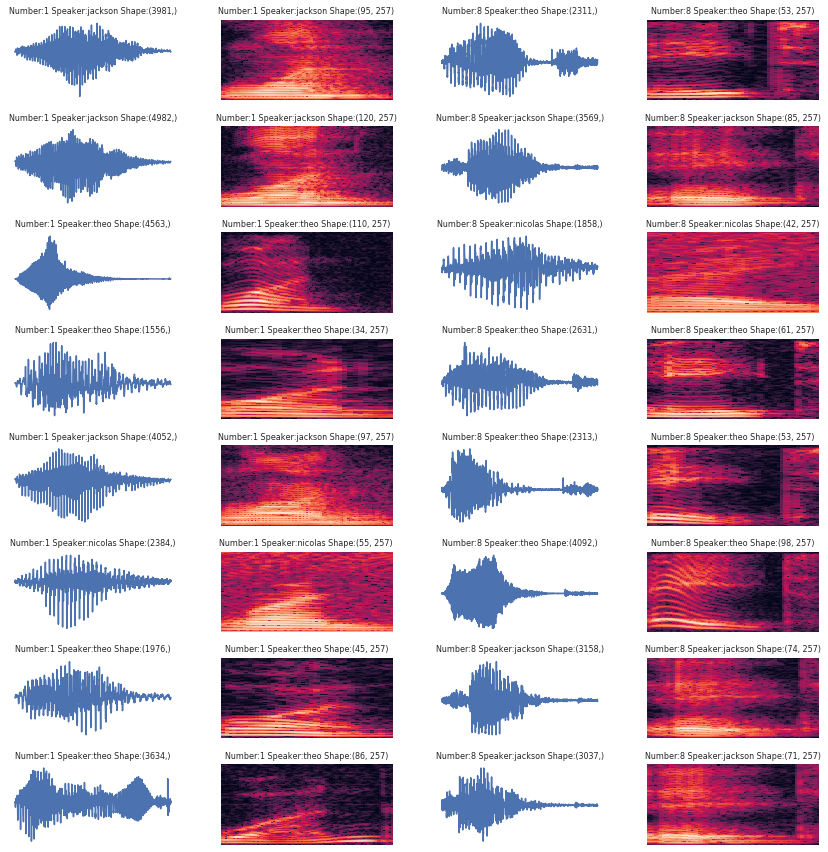

In [7]:
#@title Run this block to see the plot, and answer the above questions
fsdd = load_fsdd()
np.random.shuffle(fsdd)

files1 = [i for i in fsdd if os.path.basename(i).split('_')[0] == '1']
files8 = [i for i in fsdd if os.path.basename(i).split('_')[0] == '8']
data1 = [wav2spec(i, mel_scale=False) for i in files1[:8]]
data8 = [wav2spec(i, mel_scale=False) for i in files8[:8]]
n = len(data1)

plt.figure(figsize=(12, 12))
for i, (d1, d8) in enumerate(zip(data1, data8)):
  plt.subplot(n, 4, i * 4 + 1)
  plt.plot(d1[0])
  plt.axis('off')
  plt.title("Number:%d Speaker:%s Shape:%s" % (d1[2].numpy(), str(d1[3].numpy(), 'utf-8'), d1[0].shape),
            fontsize=8)

  ax = plt.subplot(n, 4, i * 4 + 2)
  ax.pcolorfast(d1[1].numpy().T)
  plt.axis('off')
  plt.title("Number:%d Speaker:%s Shape:%s" % (d1[2].numpy(), str(d1[3].numpy(), 'utf-8'), d1[1].shape),
            fontsize=8)

  plt.subplot(n, 4, i * 4 + 3)
  plt.plot(d8[0])
  plt.axis('off')
  plt.title("Number:%d Speaker:%s Shape:%s" % (d8[2].numpy(), str(d8[3].numpy(), 'utf-8'), d8[0].shape),
            fontsize=8)

  ax = plt.subplot(n, 4, i * 4 + 4)
  ax.pcolorfast(d8[1].numpy().T)
  plt.axis('off')
  plt.title("Number:%d Speaker:%s Shape:%s" % (d8[2].numpy(), str(d8[3].numpy(), 'utf-8'), d8[1].shape),
            fontsize=8)

_ = plt.tight_layout()

<b> ANSWERS </b>

The main difference between spectrogram and waveform-based VGGs is that the former performs 2D convolutions (across time and frequency), while the latter performs 1D convolutions (across time). Another difference is that waveform-based models do not discard the phase. Instead, they use the raw signal as it is. If this is an advantage or not, this still has to be determined for many tasks.And yes we can recognize a specific pattern i the audio signal that is relevantto distinguish number 1 or 8, also we can show 10 different spoken digit dataset recognition as an exmaple.
MNIST and FSDD, FSDD means free spoken digits dataset so in MNIST we get the images pixel-pixel MNIST and in the FSDD we get the digits in the waveform form since it is spoken.CNNs for images use two-dimensional filters that share weights across the x and y dimensions. As earlier described, this builds on the assumption that features of an image carry the same meaning regardless of their location. For this to be true, you should also assume that the x and y axes of the data have the same implications to the meaning of the content. For example, a face is still a face regardless of whether it is moved horizontally or vertically in an image.
In spectrograms, the two dimensions represent fundamentally different units, one being strength of frequency and the other being time. Moving a sound event horizontally offsets its position in time and it can be argued that a sound event means the same thing regardless of when it happens.


## **b)** Create a convolutional neural network to recognize 10 different spoken digit.

Achieve > 90% accuracy on test set.

In [14]:
# This code select 80% of audio files for training
# and the rest (20%) for testing
# If you want to know how is the sequence data (e.g. audio, text) is preprocessed, read function "create_audio_dataset" (optional)
train_files = fsdd[:int(0.8 * len(fsdd))]
test_files = fsdd[int(0.8 * len(fsdd)):]

train = create_audio_dataset(train_files, training=True)
test = create_audio_dataset(test_files, training=False)
input_shape = tf.data.experimental.get_structure(train)[0].shape[1:]
print(train)
print(test)
print("Input shape:", input_shape) # (time_dim, feature_dim)

<PrefetchDataset shapes: ((None, 300, 40), (None,)), types: (tf.float32, tf.float32)>
<PrefetchDataset shapes: ((None, 300, 40), (None,)), types: (tf.float32, tf.float32)>
Input shape: (300, 40)


In [38]:

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Conv1D, GlobalAveragePooling1D, MaxPooling1D



model = Sequential()
model.add(Conv1D(64, 3, activation='relu', input_shape=(300,40)))
model.add(Conv1D(64, 3, activation='relu'))
model.add(MaxPooling1D(3))
model.add(Conv1D(128, 3, activation='relu'))
model.add(Conv1D(128, 3, activation='relu'))
model.add(GlobalAveragePooling1D())
model.add(Dropout(0.5))
model.add(Dense(10, activation='sigmoid'))

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'],
)
n_epoch = 12
model.fit(x=train.repeat(n_epoch))
model.evaluate(test)

Train for 456 steps
10/10 [==============================] - 0s 14ms/step - loss: 0.2041 - accuracy: 0.9667


[0.20407029911875724, 0.96666664]

## **c)** What does convolutional network actually learn?

Run the following code block to re-split the dataset, then try to achieve 90% on test set!

* Could you explain what is the difference in this spliting scheme?
* Explain the output of the network in this case?

In [39]:
all_speakers = np.unique([os.path.basename(i).split('_')[1] for i in fsdd])
np.random.shuffle(all_speakers)
train_speakers = all_speakers[:2]
test_speakers = all_speakers[2:]
print("All   speakers:", all_speakers)
print("Train speakers:", train_speakers)
print("Test  speakers:", test_speakers)

train_files = [
    i for i in fsdd if os.path.basename(i).split('_')[1] in train_speakers
]
test_files = [i for i in fsdd if i not in train_files]

train = create_audio_dataset(train_files, training=True)
test = create_audio_dataset(test_files, training=False)

All   speakers: ['theo' 'nicolas' 'jackson']
Train speakers: ['theo' 'nicolas']
Test  speakers: ['jackson']


In [40]:
input_shape = tf.data.experimental.get_structure(train)[0].shape[1:]
print(input_shape)

(300, 40)


In [50]:
model = Sequential()
model.add(Conv1D(64, 3, activation='relu', input_shape=(300,40)))
model.add(Conv1D(64, 3, activation='relu'))
model.add(MaxPooling1D(3))
model.add(Conv1D(128, 3, activation='relu'))
model.add(Conv1D(128, 3, activation='relu'))
model.add(GlobalAveragePooling1D())
model.add(Dropout(0.5))
model.add(Dense(20, activation='sigmoid'))
#print(model.summary())
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'],
)
n_epoch = 250
model.fit(x=train.repeat(n_epoch))
model.evaluate(test)

Train for 8000 steps
16/16 [==============================] - 0s 10ms/step - loss: 1.2883 - accuracy: 0.8020


[1.2883152179419994, 0.802]

<b> ANSWERS </b>

In the second train/test splitting scheme we have chosen the test dataset in the following manner, <br>

test_files = [i for i in fsdd if i not in train_files]

and in the first train/test splitting scheme we have schosen the dataset in the following manner, <br>

test_files = fsdd[int(0.8 * len(fsdd)):]

so the difference is in the second dataset we are excluding the data samples which are included in the training set by the satement 
if i not in train files.So, they are different.If we test the model by using the same samples which are in the training set,
we could not understand the model accuracy very well.Means when the out of sample data were asked to the model our model may not answer
well.


# Question 3: Implementing Deep Convolutional GAN

Architecture guidelines for stable Deep Convolutional GANs `[5]`:

* Replace any pooling layers with strided convolutions (discriminator) and fractional-strided convolutions (generator).
* Use batchnorm in both the generator and the discriminator.
* Remove fully connected hidden layers for deeper architectures.
* Use `ReLU` activation in generator for all layers except for the output, which uses `Tanh`.
* Use `LeakyReLU` activation in the discriminator for all layers.

Base on this guideline, create a generator for the following GAN network to achieve reasonable fashion image.

---
To understand the transposed convolution operator (a.k.a deconvolution), visit `[1]`. A fast visualization is provided here:

* The blue boxes are input
* The cyan boxes are output
* The grey moving boxes are kernel, weight or filter

![alt text](https://drive.google.com/uc?export=view&id=1YlUML3X_p53Tk9dBOyhM5sUd0k7QHJ0W)



In [51]:
#@title Run this block to prepare the Fashion-MNIST data
def deprocess(img):
  r""" [-1, 1] -> [0,255] """
  img = 255 * (img + 1.0) / 2.0
  return tf.cast(img, tf.uint8)


def process(data):
  r""" [0,255] -> [-1, 1]"""
  img = tf.cast(data['image'], tf.float32)
  lab = data['label']
  img = (img / 255.0 - 0.5) * 2.0
  return img


BATCH_SIZE = 256
train = fmnist['train'].shuffle(10000).batch(BATCH_SIZE).map(process).prefetch(
    tf.data.experimental.AUTOTUNE)
img_shape = tf.data.experimental.get_structure(train).shape[1:]
print("Image shape:", img_shape)

Image shape: (28, 28, 1)


In [0]:
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from tensorflow.keras import layers

def make_generator():
    height, width, channels = img_shape
    model = tf.keras.Sequential()
    model.add(layers.Dense(height//4*width//4*128, use_bias=False, input_shape=(noise_dim,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((height // 4, width // 4, 128)))
    #assert model.output_shape == (None, 7, 7, 256) # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    #assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    #assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    #assert model.output_shape == (None, 28, 28, 1)

    return model


def make_discriminator(img_shape):
  return keras.Sequential([
      keras.layers.Dropout(0.3),
      keras.layers.Conv2D(32, (5, 5),
                          strides=(2, 2),
                          padding='same',
                          input_shape=img_shape,
                          use_bias=False),
      keras.layers.BatchNormalization(),
      keras.layers.LeakyReLU(),
      keras.layers.Conv2D(
          64, (5, 5), strides=(2, 2), padding='same', use_bias=False),
      keras.layers.BatchNormalization(),
      keras.layers.LeakyReLU(),
      keras.layers.Flatten(),
      keras.layers.Dense(1),
  ],
                          name="Discriminator")

**Some personal notes on training GAN** (further reading `[9]`):

* Our goal is to generate good image, i.e. good enough to fool the _discriminator_. Hence, if we get an "idiot" _discriminator_, it results a pointless _generator_. As a results, one of the prerequisites of GAN is an optimal _discriminator_, in the other words, the discriminator loss should be smaller than generator loss. But ...
* The goal of GAN is neither optimizing _discriminator_ nor _generator_. We want to reach the _equilibrium state_ when both player playing an optimal game. This means both generator and discriminator loss must NOT go to zero, and the game converge to a more stable process (with lower variance) in the end. Don't panic when neither of the losses going down, or they are jumping around randomly sometimes.
* GAN is very sensitive to hyperparameters: the learning rate, the choice of optimization algorithm, the network depth and number of units of discriminator and generator. Be patience, keep your learning rate down and your curiosity up, you will see something after about 20 epochs.

Anyway, running the following code block to debug your generator, read it in detail if you want to know how to train a GAN network in practice.

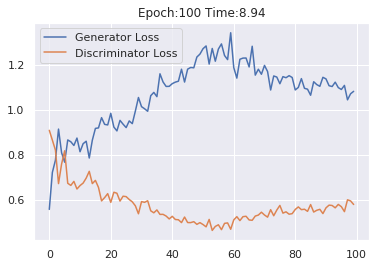

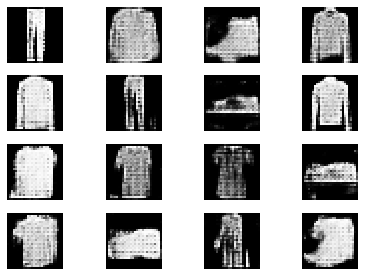

In [60]:

G = make_generator()
D = make_discriminator(img_shape=img_shape)
#print(G.summary())
#print(D.summary())

cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits


def discriminator_loss(real_output, fake_output):
  return cross_entropy(
      tf.concat([tf.ones_like(real_output),
                 tf.zeros_like(fake_output)], axis=0),
      tf.concat([real_output, fake_output], axis=0))


def generator_loss(fake_output):
  return cross_entropy(tf.ones_like(fake_output), fake_output)


g_optimizer = keras.optimizers.Adam(1e-4)
d_optimizer = keras.optimizers.Adam(1e-4)


@tf.function
def train_step(images):
  noise = tf.random.normal([images.shape[0], noise_dim])

  with tf.GradientTape() as g_tape, tf.GradientTape() as d_tape:
    generated_images = G(noise, training=True)

    real_output = D(images, training=True)
    fake_output = D(generated_images, training=True)

    gen_loss = tf.reduce_mean(generator_loss(fake_output))
    disc_loss = tf.reduce_mean(discriminator_loss(real_output, fake_output))

  grad_g = g_tape.gradient(gen_loss, G.trainable_variables)
  grad_d = d_tape.gradient(disc_loss, D.trainable_variables)

  g_optimizer.apply_gradients(zip(grad_g, G.trainable_variables))
  d_optimizer.apply_gradients(zip(grad_d, D.trainable_variables))
  return gen_loss, disc_loss


seed = tf.random.normal([16, noise_dim])
g_losses = []
d_losses = []
for epoch in range(100):
  start_time = time.time()
  losses = [train_step(X) for X in train]
  g_loss = np.mean([i[0] for i in losses])
  d_loss = np.mean([i[1] for i in losses])
  g_losses.append(g_loss)
  d_losses.append(d_loss)

  display.clear_output(wait=True)
  plt.figure()
  plt.plot(g_losses, label='Generator Loss')
  plt.plot(d_losses, label='Discriminator Loss')
  plt.title("Epoch:%d Time:%.2f" % (epoch + 1, time.time() - start_time))
  plt.legend()
  plt.show()

  img = deprocess(G(seed, training=False)).numpy()
  plt.figure()
  for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(img[i][:, :, 0], cmap='gray')
    plt.axis('off')
  plt.tight_layout()
  plt.show()

Further reading in GANs if you are interested:

* GAN open question: https://distill.pub/2019/gan-open-problems/
* A Discussion of Adversarial Examples Are Not Bugs, They Are Features: https://distill.pub/2019/advex-bugs-discussion/
* Generative Adversarial Networks: An Overview: https://arxiv.org/pdf/1710.07035.pdf

# More visualization for the convolution operator

For more interactive guide and mathematical explaination `[2]`

The following figure show the detail of calculating the output for convolution:

* The left image is how a kernel and input are convoluted in single feature map. 
* The right image shows how multiple feature maps are combined into final outputs.

![alt text](https://drive.google.com/uc?export=view&id=1DnSEW5JZvt3auq0lF9gSuF-oSROR34lB)

The following figure illustrates the effect of padding and striding on the output (left figure), and how max pooling is performed (right image).
![alt text](https://drive.google.com/uc?export=view&id=1UPjiCCGR2N7_A88s7aBG9zTeau2-HZKY)
